<a href="https://colab.research.google.com/github/ArshT/Pytorch_Practice/blob/master/DCGAN_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
from os.path import exists

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FashionMNIST(root='./data/', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = FashionMNIST(root='./data/', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100,1024,4,1,0)
        self.deconv1_bn = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024,512, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512,256, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256,128, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128, 1, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.leaky_relu(self.deconv1_bn(self.deconv1(input)), 0.2)
        x = F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 4, 2, 1)
        self.conv2 = nn.Conv2d(128,256, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256,512, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512,1024, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        return x
    
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if True and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

print(generator)
print("")
print(discriminator)



Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

Discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), paddin

Training ...
Batch: 50 Generator Loss: 1.736116749048233 Discriminator Loss: 0.3820037615299225
Batch: 100 Generator Loss: 2.1534343338012696 Discriminator Loss: 0.33262096405029296
Batch: 150 Generator Loss: 2.201292462348938 Discriminator Loss: 0.3290348571538925
Batch: 200 Generator Loss: 2.21288850069046 Discriminator Loss: 0.32922600030899046
Batch: 250 Generator Loss: 2.1874517011642456 Discriminator Loss: 0.3296214646100998
Batch: 300 Generator Loss: 2.2038950610160826 Discriminator Loss: 0.3302766877412796
Batch: 350 Generator Loss: 2.189832890033722 Discriminator Loss: 0.3297223347425461
Batch: 400 Generator Loss: 2.1768693280220033 Discriminator Loss: 0.32933232963085174
Batch: 450 Generator Loss: 2.19237774848938 Discriminator Loss: 0.3300136786699295


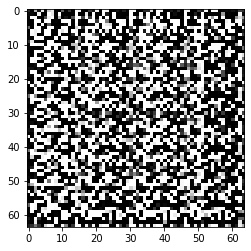

Epoch [1 / 50] average loss generator vs. discrim.: 2.141934 vs. 0.335501

Batch: 50 Generator Loss: 2.1659130120277403 Discriminator Loss: 0.328847416639328
Batch: 100 Generator Loss: 2.1770031094551086 Discriminator Loss: 0.3294047075510025
Batch: 150 Generator Loss: 2.168567144870758 Discriminator Loss: 0.32874084770679474
Batch: 200 Generator Loss: 2.1641758131980895 Discriminator Loss: 0.3284228253364563
Batch: 250 Generator Loss: 2.1690457034111024 Discriminator Loss: 0.3286111557483673
Batch: 300 Generator Loss: 2.1584016418457033 Discriminator Loss: 0.3285594475269318
Batch: 350 Generator Loss: 2.1769867658615114 Discriminator Loss: 0.32920504093170166
Batch: 400 Generator Loss: 2.1574870109558106 Discriminator Loss: 0.32841955542564394
Batch: 450 Generator Loss: 2.1519401550292967 Discriminator Loss: 0.3281211584806442


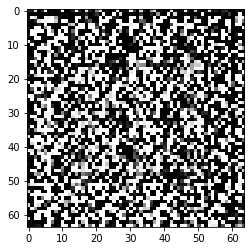

Epoch [2 / 50] average loss generator vs. discrim.: 2.166103 vs. 0.328697

Batch: 50 Generator Loss: 2.1597969007492064 Discriminator Loss: 0.32832598567008975
Batch: 100 Generator Loss: 2.182903950214386 Discriminator Loss: 0.32903569638729097
Batch: 150 Generator Loss: 2.1996504831314088 Discriminator Loss: 0.3295668065547943
Batch: 200 Generator Loss: 2.204985089302063 Discriminator Loss: 0.32993902325630187
Batch: 250 Generator Loss: 2.2195520067214964 Discriminator Loss: 0.33038806974887847
Batch: 300 Generator Loss: 2.2011294198036193 Discriminator Loss: 0.3295326524972916
Batch: 350 Generator Loss: 2.216934952735901 Discriminator Loss: 0.3302343338727951
Batch: 400 Generator Loss: 2.20123078584671 Discriminator Loss: 0.32982221961021424
Batch: 450 Generator Loss: 2.2338115429878234 Discriminator Loss: 0.33069465577602386


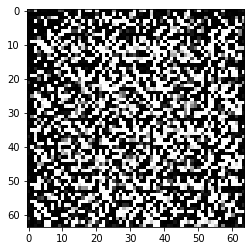

Epoch [3 / 50] average loss generator vs. discrim.: 2.201838 vs. 0.329747

Batch: 50 Generator Loss: 2.195334343910217 Discriminator Loss: 0.32940311431884767
Batch: 100 Generator Loss: 2.1983103346824646 Discriminator Loss: 0.3293734973669052
Batch: 150 Generator Loss: 2.182008612155914 Discriminator Loss: 0.32891654908657075
Batch: 200 Generator Loss: 2.1687327909469603 Discriminator Loss: 0.32869485914707186
Batch: 250 Generator Loss: 2.2034254002571108 Discriminator Loss: 0.32977108836174013
Batch: 300 Generator Loss: 2.186363024711609 Discriminator Loss: 0.3288941901922226
Batch: 350 Generator Loss: 2.1792199063301085 Discriminator Loss: 0.32875726580619813
Batch: 400 Generator Loss: 2.1917018699645996 Discriminator Loss: 0.3292666417360306
Batch: 450 Generator Loss: 2.1820337057113646 Discriminator Loss: 0.3287682694196701


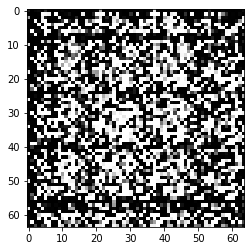

Epoch [4 / 50] average loss generator vs. discrim.: 2.188282 vs. 0.329096

Batch: 50 Generator Loss: 2.19808375120163 Discriminator Loss: 0.32923622608184816
Batch: 100 Generator Loss: 2.1799716925621033 Discriminator Loss: 0.32875143110752103
Batch: 150 Generator Loss: 2.1653362989425657 Discriminator Loss: 0.3280775272846222
Batch: 200 Generator Loss: 2.2019879484176634 Discriminator Loss: 0.3291505432128906
Batch: 250 Generator Loss: 2.195355923175812 Discriminator Loss: 0.3293503576517105
Batch: 300 Generator Loss: 2.1801740384101866 Discriminator Loss: 0.32848695158958435
Batch: 350 Generator Loss: 2.176535930633545 Discriminator Loss: 0.32891597628593444
Batch: 400 Generator Loss: 2.1845001769065857 Discriminator Loss: 0.32886320531368257
Batch: 450 Generator Loss: 2.177813651561737 Discriminator Loss: 0.32867691993713377


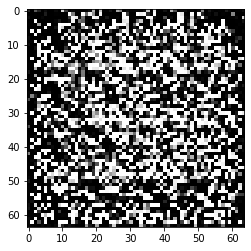

Epoch [5 / 50] average loss generator vs. discrim.: 2.184454 vs. 0.328874

Batch: 50 Generator Loss: 2.1923137140274047 Discriminator Loss: 0.3295521014928818
Batch: 100 Generator Loss: 2.170762264728546 Discriminator Loss: 0.3282708829641342
Batch: 150 Generator Loss: 2.1693713569641115 Discriminator Loss: 0.3284075778722763
Batch: 200 Generator Loss: 2.1842197442054747 Discriminator Loss: 0.3288701367378235
Batch: 250 Generator Loss: 2.19203227519989 Discriminator Loss: 0.32889711141586303
Batch: 300 Generator Loss: 2.181087074279785 Discriminator Loss: 0.32901107966899873
Batch: 350 Generator Loss: 2.162340545654297 Discriminator Loss: 0.32814648270606994
Batch: 400 Generator Loss: 2.156611907482147 Discriminator Loss: 0.3280622506141663
Batch: 450 Generator Loss: 2.1482499718666075 Discriminator Loss: 0.3275673699378967


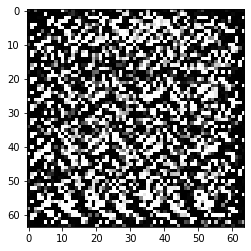

Epoch [6 / 50] average loss generator vs. discrim.: 2.172642 vs. 0.328506

Batch: 50 Generator Loss: 2.143969612121582 Discriminator Loss: 0.32740106880664827
Batch: 100 Generator Loss: 2.1631017541885376 Discriminator Loss: 0.3280632609128952
Batch: 150 Generator Loss: 2.1695037412643434 Discriminator Loss: 0.32852979123592374
Batch: 200 Generator Loss: 2.163872683048248 Discriminator Loss: 0.3282597970962524
Batch: 250 Generator Loss: 2.144438097476959 Discriminator Loss: 0.32735097587108614
Batch: 300 Generator Loss: 2.151108195781708 Discriminator Loss: 0.3277904725074768
Batch: 350 Generator Loss: 2.139474768638611 Discriminator Loss: 0.32731822550296785
Batch: 400 Generator Loss: 2.143519871234894 Discriminator Loss: 0.32762093484401705
Batch: 450 Generator Loss: 2.1513098526000975 Discriminator Loss: 0.3279255545139313


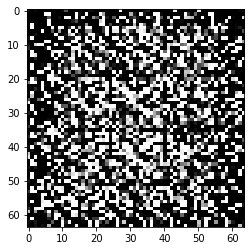

Epoch [7 / 50] average loss generator vs. discrim.: 2.152934 vs. 0.327826

Batch: 50 Generator Loss: 2.14107239484787 Discriminator Loss: 0.3276389443874359
Batch: 100 Generator Loss: 2.14389146566391 Discriminator Loss: 0.32754663467407225
Batch: 150 Generator Loss: 2.140989804267883 Discriminator Loss: 0.32725353598594664
Batch: 200 Generator Loss: 2.1453698110580444 Discriminator Loss: 0.3274580097198486
Batch: 250 Generator Loss: 2.1377660965919496 Discriminator Loss: 0.3273902612924576
Batch: 300 Generator Loss: 2.1380147337913513 Discriminator Loss: 0.32742531478405
Batch: 350 Generator Loss: 2.1451904559135437 Discriminator Loss: 0.32731910824775695
Batch: 400 Generator Loss: 2.1420640897750856 Discriminator Loss: 0.3274407237768173
Batch: 450 Generator Loss: 2.127246971130371 Discriminator Loss: 0.3266330087184906


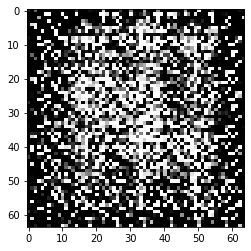

Epoch [8 / 50] average loss generator vs. discrim.: 2.139462 vs. 0.327331

Batch: 50 Generator Loss: 2.131189935207367 Discriminator Loss: 0.3271775847673416
Batch: 100 Generator Loss: 2.1360270309448244 Discriminator Loss: 0.32708064138889315
Batch: 150 Generator Loss: 2.1403592824935913 Discriminator Loss: 0.327085981965065
Batch: 200 Generator Loss: 2.1327424025535584 Discriminator Loss: 0.32722384214401246
Batch: 250 Generator Loss: 2.137750744819641 Discriminator Loss: 0.32709039509296417
Batch: 300 Generator Loss: 2.1346280169487 Discriminator Loss: 0.3271417599916458
Batch: 350 Generator Loss: 2.1472934770584104 Discriminator Loss: 0.3273871427774429
Batch: 400 Generator Loss: 2.153788323402405 Discriminator Loss: 0.3277247041463852
Batch: 450 Generator Loss: 2.135125234127045 Discriminator Loss: 0.327098525762558


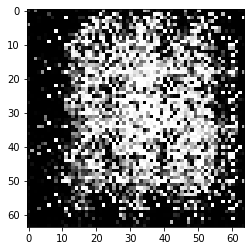

Epoch [9 / 50] average loss generator vs. discrim.: 2.138965 vs. 0.327194

Batch: 50 Generator Loss: 2.1591832995414735 Discriminator Loss: 0.32803540885448457
Batch: 100 Generator Loss: 2.169251947402954 Discriminator Loss: 0.3281885975599289
Batch: 150 Generator Loss: 2.1985796070098877 Discriminator Loss: 0.32933360278606416
Batch: 200 Generator Loss: 2.253376247882843 Discriminator Loss: 0.33337888717651365
Batch: 250 Generator Loss: 2.1484845304489135 Discriminator Loss: 0.3266632145643234
Batch: 300 Generator Loss: 2.192667992115021 Discriminator Loss: 0.3288249796628952
Batch: 350 Generator Loss: 2.222113788127899 Discriminator Loss: 0.3299995058774948
Batch: 400 Generator Loss: 2.176343545913696 Discriminator Loss: 0.3289929574728012
Batch: 450 Generator Loss: 2.194151201248169 Discriminator Loss: 0.32910886347293855


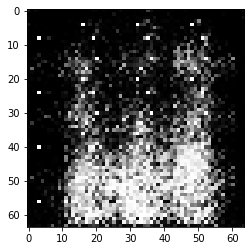

Epoch [10 / 50] average loss generator vs. discrim.: 2.189877 vs. 0.329209

Batch: 50 Generator Loss: 2.142414312362671 Discriminator Loss: 0.32768390953540805
Batch: 100 Generator Loss: 2.140622045993805 Discriminator Loss: 0.32771348536014555
Batch: 150 Generator Loss: 2.1502159214019776 Discriminator Loss: 0.327622332572937
Batch: 200 Generator Loss: 2.1524419522285463 Discriminator Loss: 0.32811909675598144
Batch: 250 Generator Loss: 2.204020154476166 Discriminator Loss: 0.33125153064727786
Batch: 300 Generator Loss: 2.250413362979889 Discriminator Loss: 0.33088275194168093
Batch: 350 Generator Loss: 2.1471710538864137 Discriminator Loss: 0.3279556542634964
Batch: 400 Generator Loss: 2.148531322479248 Discriminator Loss: 0.32790178298950196
Batch: 450 Generator Loss: 2.1228812074661256 Discriminator Loss: 0.3269582557678223


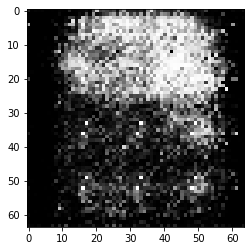

Epoch [11 / 50] average loss generator vs. discrim.: 2.160437 vs. 0.328402

Batch: 50 Generator Loss: 2.1294743466377257 Discriminator Loss: 0.3275024515390396
Batch: 100 Generator Loss: 2.1377272987365723 Discriminator Loss: 0.32725513219833374
Batch: 150 Generator Loss: 2.1224631595611574 Discriminator Loss: 0.3266686201095581
Batch: 200 Generator Loss: 2.1183848905563356 Discriminator Loss: 0.32644160091876984
Batch: 250 Generator Loss: 2.144289283752441 Discriminator Loss: 0.3276967203617096
Batch: 300 Generator Loss: 2.1290075397491455 Discriminator Loss: 0.3267315548658371
Batch: 350 Generator Loss: 2.1406467580795288 Discriminator Loss: 0.3273839867115021
Batch: 400 Generator Loss: 2.1566217374801635 Discriminator Loss: 0.32775947511196135
Batch: 450 Generator Loss: 2.1782748603820803 Discriminator Loss: 0.32888265311717985


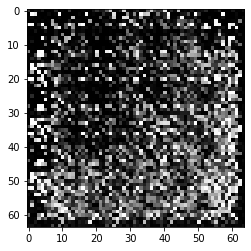

Epoch [12 / 50] average loss generator vs. discrim.: 2.141089 vs. 0.327453

Batch: 50 Generator Loss: 2.2063976740837097 Discriminator Loss: 0.3297557860612869
Batch: 100 Generator Loss: 2.2044205808639528 Discriminator Loss: 0.3298521441221237
Batch: 150 Generator Loss: 2.173584222793579 Discriminator Loss: 0.32844885408878327
Batch: 200 Generator Loss: 2.1716061854362487 Discriminator Loss: 0.32858031392097475
Batch: 250 Generator Loss: 2.15950129032135 Discriminator Loss: 0.3280119073390961
Batch: 300 Generator Loss: 2.1467753219604493 Discriminator Loss: 0.327574365735054
Batch: 350 Generator Loss: 2.1465767788887025 Discriminator Loss: 0.32737924814224245
Batch: 400 Generator Loss: 2.133154520988464 Discriminator Loss: 0.32690550982952116
Batch: 450 Generator Loss: 2.132667920589447 Discriminator Loss: 0.32712109804153444


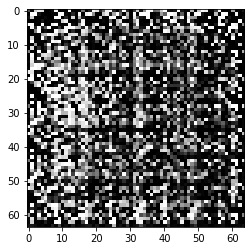

Epoch [13 / 50] average loss generator vs. discrim.: 2.162168 vs. 0.328131

Batch: 50 Generator Loss: 2.127238986492157 Discriminator Loss: 0.32668173015117646
Batch: 100 Generator Loss: 2.126737298965454 Discriminator Loss: 0.3265605938434601
Batch: 150 Generator Loss: 2.1353758788108825 Discriminator Loss: 0.3267726707458496
Batch: 200 Generator Loss: 2.12418630361557 Discriminator Loss: 0.3265161895751953
Batch: 250 Generator Loss: 2.126350362300873 Discriminator Loss: 0.32678081810474396
Batch: 300 Generator Loss: 2.128339204788208 Discriminator Loss: 0.32646154701709745
Batch: 350 Generator Loss: 2.122131359577179 Discriminator Loss: 0.32638540923595427
Batch: 400 Generator Loss: 2.1402171564102175 Discriminator Loss: 0.32699381053447724
Batch: 450 Generator Loss: 2.1261171531677245 Discriminator Loss: 0.32650880098342894


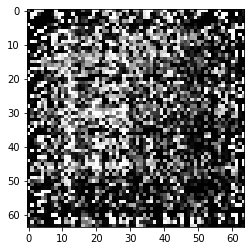

Epoch [14 / 50] average loss generator vs. discrim.: 2.129100 vs. 0.326629

Batch: 50 Generator Loss: 2.13659973859787 Discriminator Loss: 0.32681882977485655
Batch: 100 Generator Loss: 2.1275860118865966 Discriminator Loss: 0.32655713975429534
Batch: 150 Generator Loss: 2.1137545347213744 Discriminator Loss: 0.3260466134548187
Batch: 200 Generator Loss: 2.12193284034729 Discriminator Loss: 0.3264228904247284
Batch: 250 Generator Loss: 2.1177127623558043 Discriminator Loss: 0.3262443470954895
Batch: 300 Generator Loss: 2.1247144412994383 Discriminator Loss: 0.32626307547092437
Batch: 350 Generator Loss: 2.119683802127838 Discriminator Loss: 0.3259837585687637
Batch: 400 Generator Loss: 2.1541865944862364 Discriminator Loss: 0.32758040010929107
Batch: 450 Generator Loss: 2.2224622893333437 Discriminator Loss: 0.3332667952775955


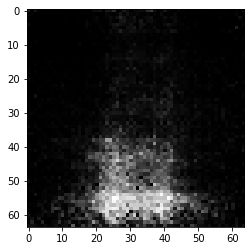

Epoch [15 / 50] average loss generator vs. discrim.: 2.151918 vs. 0.328062

Batch: 50 Generator Loss: 2.3902586007118227 Discriminator Loss: 0.3512660509347916
Batch: 100 Generator Loss: 2.0859911751747133 Discriminator Loss: 0.3578753972053528
Batch: 150 Generator Loss: 2.0430177211761475 Discriminator Loss: 0.3805803734064102
Batch: 200 Generator Loss: 2.0752999591827392 Discriminator Loss: 0.38010219752788543
Batch: 250 Generator Loss: 2.027331395149231 Discriminator Loss: 0.3560435676574707
Batch: 300 Generator Loss: 2.0254796075820924 Discriminator Loss: 0.35747818648815155
Batch: 350 Generator Loss: 2.0319363713264464 Discriminator Loss: 0.3562764024734497
Batch: 400 Generator Loss: 2.062962191104889 Discriminator Loss: 0.34881735205650327
Batch: 450 Generator Loss: 2.038872573375702 Discriminator Loss: 0.34187741577625275


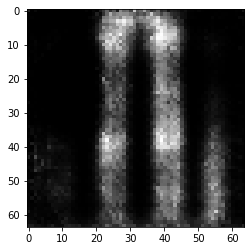

Epoch [16 / 50] average loss generator vs. discrim.: 2.086637 vs. 0.358116

Batch: 50 Generator Loss: 2.1783507442474366 Discriminator Loss: 0.33287131786346436
Batch: 100 Generator Loss: 2.23233140707016 Discriminator Loss: 0.33525401711463926
Batch: 150 Generator Loss: 2.105795328617096 Discriminator Loss: 0.37016127705574037
Batch: 200 Generator Loss: 1.9474846291542054 Discriminator Loss: 0.34669804096221923
Batch: 250 Generator Loss: 2.0322682094573974 Discriminator Loss: 0.3410524713993073
Batch: 300 Generator Loss: 2.0740499663352967 Discriminator Loss: 0.34040910422801973
Batch: 350 Generator Loss: 2.1162760734558104 Discriminator Loss: 0.34380078613758086
Batch: 400 Generator Loss: 1.9796773600578308 Discriminator Loss: 0.3475941860675812
Batch: 450 Generator Loss: 1.9964507961273192 Discriminator Loss: 0.34293690919876096


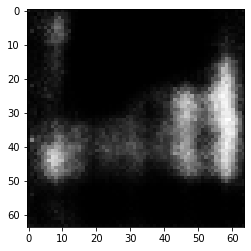

Epoch [17 / 50] average loss generator vs. discrim.: 2.072487 vs. 0.344543

Batch: 50 Generator Loss: 2.0159745407104492 Discriminator Loss: 0.34299320459365845
Batch: 100 Generator Loss: 2.0271086573600767 Discriminator Loss: 0.3451053822040558
Batch: 150 Generator Loss: 2.0249368381500243 Discriminator Loss: 0.34070665538311007
Batch: 200 Generator Loss: 2.0083050966262816 Discriminator Loss: 0.34586997985839846
Batch: 250 Generator Loss: 2.0210145783424376 Discriminator Loss: 0.34465668618679046
Batch: 300 Generator Loss: 2.0484980821609495 Discriminator Loss: 0.34485465943813326
Batch: 350 Generator Loss: 2.056559724807739 Discriminator Loss: 0.34557708621025085
Batch: 400 Generator Loss: 2.042274925708771 Discriminator Loss: 0.3399968582391739
Batch: 450 Generator Loss: 2.035131528377533 Discriminator Loss: 0.3425528210401535


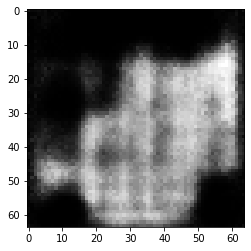

Epoch [18 / 50] average loss generator vs. discrim.: 2.032720 vs. 0.343904

Batch: 50 Generator Loss: 2.013924970626831 Discriminator Loss: 0.35264367759227755
Batch: 100 Generator Loss: 1.987098398208618 Discriminator Loss: 0.40486029148101804
Batch: 150 Generator Loss: 2.1291059470176696 Discriminator Loss: 0.33758542001247405
Batch: 200 Generator Loss: 2.056015410423279 Discriminator Loss: 0.36304224967956544
Batch: 250 Generator Loss: 1.8932401943206787 Discriminator Loss: 0.34769629895687104
Batch: 300 Generator Loss: 1.946000602245331 Discriminator Loss: 0.347939555644989
Batch: 350 Generator Loss: 1.942537853717804 Discriminator Loss: 0.3465082651376724
Batch: 400 Generator Loss: 1.9729084157943726 Discriminator Loss: 0.3458556926250458
Batch: 450 Generator Loss: 2.054701855182648 Discriminator Loss: 0.34388200998306273


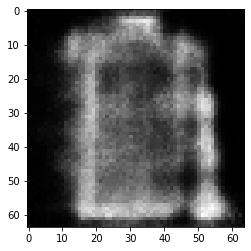

Epoch [19 / 50] average loss generator vs. discrim.: 2.001761 vs. 0.353825

Batch: 50 Generator Loss: 2.0101399087905882 Discriminator Loss: 0.34941200017929075
Batch: 100 Generator Loss: 2.0161509108543396 Discriminator Loss: 0.3486603158712387
Batch: 150 Generator Loss: 1.9932992100715636 Discriminator Loss: 0.35020151615142825
Batch: 200 Generator Loss: 1.9788542008399963 Discriminator Loss: 0.3403222280740738
Batch: 250 Generator Loss: 1.997138442993164 Discriminator Loss: 0.351663264632225
Batch: 300 Generator Loss: 2.024756679534912 Discriminator Loss: 0.34701219081878665
Batch: 350 Generator Loss: 2.0254065704345705 Discriminator Loss: 0.3402115124464035
Batch: 400 Generator Loss: 2.0126486825942993 Discriminator Loss: 0.3417016863822937
Batch: 450 Generator Loss: 2.0199700593948364 Discriminator Loss: 0.4093214905261993


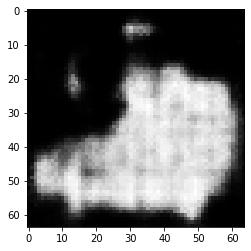

Epoch [20 / 50] average loss generator vs. discrim.: 2.004254 vs. 0.352977

Batch: 50 Generator Loss: 1.9040783834457398 Discriminator Loss: 0.3464589238166809
Batch: 100 Generator Loss: 1.9637525177001953 Discriminator Loss: 0.3435035610198975
Batch: 150 Generator Loss: 1.9944044375419616 Discriminator Loss: 0.3438962399959564
Batch: 200 Generator Loss: 2.0311773681640624 Discriminator Loss: 0.3417468124628067
Batch: 250 Generator Loss: 1.993558599948883 Discriminator Loss: 0.34644111633300784
Batch: 300 Generator Loss: 2.0201112914085386 Discriminator Loss: 0.34325615465641024
Batch: 350 Generator Loss: 2.0303139448165894 Discriminator Loss: 0.34652145266532897
Batch: 400 Generator Loss: 2.0175067830085753 Discriminator Loss: 0.34270319163799284
Batch: 450 Generator Loss: 2.042654767036438 Discriminator Loss: 0.3397637975215912


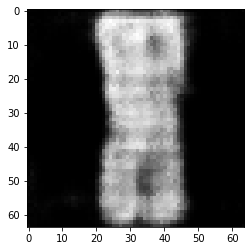

Epoch [21 / 50] average loss generator vs. discrim.: 2.001057 vs. 0.344128

Batch: 50 Generator Loss: 2.0483132433891296 Discriminator Loss: 0.34345560789108276
Batch: 100 Generator Loss: 2.0100459122657774 Discriminator Loss: 0.34635900318622587
Batch: 150 Generator Loss: 1.9987966990470887 Discriminator Loss: 0.3400748294591904
Batch: 200 Generator Loss: 2.0047658848762513 Discriminator Loss: 0.34410149037837984
Batch: 250 Generator Loss: 2.003218810558319 Discriminator Loss: 0.3380939692258835
Batch: 300 Generator Loss: 2.030820608139038 Discriminator Loss: 0.3416830164194107
Batch: 350 Generator Loss: 2.043909831047058 Discriminator Loss: 0.339537752866745
Batch: 400 Generator Loss: 2.0597275066375733 Discriminator Loss: 0.34198823034763337
Batch: 450 Generator Loss: 2.051249361038208 Discriminator Loss: 0.34078933656215665


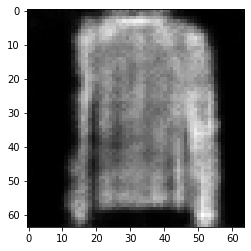

Epoch [22 / 50] average loss generator vs. discrim.: 2.029843 vs. 0.341572

Batch: 50 Generator Loss: 2.062439515590668 Discriminator Loss: 0.33966403126716616
Batch: 100 Generator Loss: 2.066806981563568 Discriminator Loss: 0.3388850301504135
Batch: 150 Generator Loss: 2.091338276863098 Discriminator Loss: 0.34014523327350615
Batch: 200 Generator Loss: 2.0507834911346436 Discriminator Loss: 0.3420881563425064
Batch: 250 Generator Loss: 2.0180828762054444 Discriminator Loss: 0.33755150318145755
Batch: 300 Generator Loss: 2.0421860027313232 Discriminator Loss: 0.3406330740451813
Batch: 350 Generator Loss: 2.0239467191696168 Discriminator Loss: 0.3404651153087616
Batch: 400 Generator Loss: 2.0514622044563295 Discriminator Loss: 0.33726965725421904
Batch: 450 Generator Loss: 2.069567461013794 Discriminator Loss: 0.34240359961986544


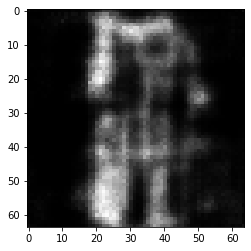

Epoch [23 / 50] average loss generator vs. discrim.: 2.052988 vs. 0.339747

Batch: 50 Generator Loss: 2.036317014694214 Discriminator Loss: 0.3381819850206375
Batch: 100 Generator Loss: 2.047563736438751 Discriminator Loss: 0.34178144931793214
Batch: 150 Generator Loss: 2.044191954135895 Discriminator Loss: 0.338412863612175
Batch: 200 Generator Loss: 2.0612531685829163 Discriminator Loss: 0.33891229569911957
Batch: 250 Generator Loss: 2.073717713356018 Discriminator Loss: 0.33935332715511324
Batch: 300 Generator Loss: 2.0629052925109863 Discriminator Loss: 0.33694700777530673
Batch: 350 Generator Loss: 2.059039206504822 Discriminator Loss: 0.3380590045452118
Batch: 400 Generator Loss: 2.0565185356140137 Discriminator Loss: 0.33866987884044647
Batch: 450 Generator Loss: 2.0378208565711975 Discriminator Loss: 0.34115810751914977


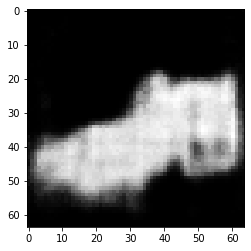

Epoch [24 / 50] average loss generator vs. discrim.: 2.052916 vs. 0.339150

Batch: 50 Generator Loss: 2.0511665749549866 Discriminator Loss: 0.3376533716917038
Batch: 100 Generator Loss: 2.135917600393295 Discriminator Loss: 0.3912740409374237
Batch: 150 Generator Loss: 1.9565415358543397 Discriminator Loss: 0.35626181662082673
Batch: 200 Generator Loss: 1.9589934873580932 Discriminator Loss: 0.34073359429836275
Batch: 250 Generator Loss: 2.024199743270874 Discriminator Loss: 0.3391631269454956
Batch: 300 Generator Loss: 2.0657598876953127 Discriminator Loss: 0.34016614496707914
Batch: 350 Generator Loss: 2.046037018299103 Discriminator Loss: 0.3359495162963867
Batch: 400 Generator Loss: 2.0826828289031982 Discriminator Loss: 0.3359923756122589
Batch: 450 Generator Loss: 2.0870268082618715 Discriminator Loss: 0.33634613156318666


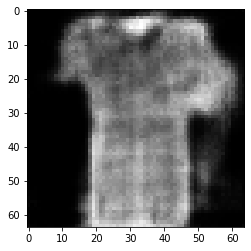

Epoch [25 / 50] average loss generator vs. discrim.: 2.045358 vs. 0.345495

Batch: 50 Generator Loss: 2.0646888756752015 Discriminator Loss: 0.3385294264554977
Batch: 100 Generator Loss: 2.077907667160034 Discriminator Loss: 0.3380700099468231
Batch: 150 Generator Loss: 2.0578428220748903 Discriminator Loss: 0.3353116208314896
Batch: 200 Generator Loss: 2.0647348880767824 Discriminator Loss: 0.3375774145126343
Batch: 250 Generator Loss: 2.0689849424362183 Discriminator Loss: 0.33470551133155824
Batch: 300 Generator Loss: 2.072653386592865 Discriminator Loss: 0.3393893665075302
Batch: 350 Generator Loss: 2.0586235523223877 Discriminator Loss: 0.33822102785110475
Batch: 400 Generator Loss: 2.0644254946708678 Discriminator Loss: 0.33674476385116575
Batch: 450 Generator Loss: 2.07664119720459 Discriminator Loss: 0.3410794305801392


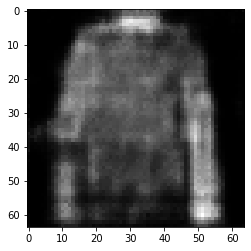

Epoch [26 / 50] average loss generator vs. discrim.: 2.067271 vs. 0.337670

Batch: 50 Generator Loss: 2.0600346875190736 Discriminator Loss: 0.33671786427497863
Batch: 100 Generator Loss: 2.068848366737366 Discriminator Loss: 0.33466231942176816
Batch: 150 Generator Loss: 2.0708206200599673 Discriminator Loss: 0.33802011847496033
Batch: 200 Generator Loss: 2.059082081317902 Discriminator Loss: 0.3362689447402954
Batch: 250 Generator Loss: 2.059310038089752 Discriminator Loss: 0.3325112175941467
Batch: 300 Generator Loss: 2.0774905920028686 Discriminator Loss: 0.33865204751491546
Batch: 350 Generator Loss: 2.094980857372284 Discriminator Loss: 0.3378414708375931
Batch: 400 Generator Loss: 2.073487074375153 Discriminator Loss: 0.3359463173151016
Batch: 450 Generator Loss: 2.0537902164459227 Discriminator Loss: 0.34129538357257844


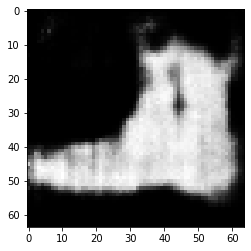

Epoch [27 / 50] average loss generator vs. discrim.: 2.068358 vs. 0.336782

Batch: 50 Generator Loss: 2.074393846988678 Discriminator Loss: 0.3359614706039429
Batch: 100 Generator Loss: 2.09143746137619 Discriminator Loss: 0.3355058741569519
Batch: 150 Generator Loss: 2.095867476463318 Discriminator Loss: 0.3346681880950928
Batch: 200 Generator Loss: 2.0823746013641355 Discriminator Loss: 0.33505465984344485
Batch: 250 Generator Loss: 2.083108642101288 Discriminator Loss: 0.3343515747785568
Batch: 300 Generator Loss: 2.102938370704651 Discriminator Loss: 0.33674135386943815
Batch: 350 Generator Loss: 2.0725415110588075 Discriminator Loss: 0.3387810015678406
Batch: 400 Generator Loss: 2.0568350839614866 Discriminator Loss: 0.33652565598487855
Batch: 450 Generator Loss: 2.068695480823517 Discriminator Loss: 0.3363784492015839


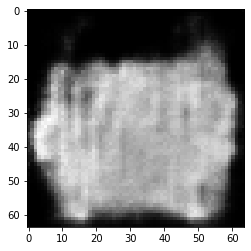

Epoch [28 / 50] average loss generator vs. discrim.: 2.080264 vs. 0.335955

Batch: 50 Generator Loss: 2.0722437000274656 Discriminator Loss: 0.33545460283756257
Batch: 100 Generator Loss: 2.074769580364227 Discriminator Loss: 0.33686814725399017
Batch: 150 Generator Loss: 2.1022231233119966 Discriminator Loss: 0.37528165459632873
Batch: 200 Generator Loss: 2.0399926590919493 Discriminator Loss: 0.34061738550662995
Batch: 250 Generator Loss: 2.0409429979324343 Discriminator Loss: 0.3373863673210144
Batch: 300 Generator Loss: 2.0860722851753235 Discriminator Loss: 0.3342124110460281
Batch: 350 Generator Loss: 2.082491362094879 Discriminator Loss: 0.3332479816675186
Batch: 400 Generator Loss: 2.077547163963318 Discriminator Loss: 0.3346265232563019
Batch: 450 Generator Loss: 2.077194745540619 Discriminator Loss: 0.3320745569467545


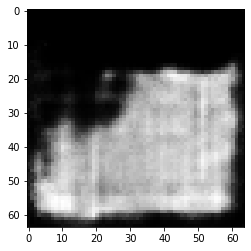

Epoch [29 / 50] average loss generator vs. discrim.: 2.072979 vs. 0.339820

Batch: 50 Generator Loss: 2.079473042488098 Discriminator Loss: 0.3337161332368851
Batch: 100 Generator Loss: 2.081325397491455 Discriminator Loss: 0.3332225924730301
Batch: 150 Generator Loss: 2.0812311148643494 Discriminator Loss: 0.3338951331377029
Batch: 200 Generator Loss: 2.080034339427948 Discriminator Loss: 0.3350532275438309
Batch: 250 Generator Loss: 2.0724958777427673 Discriminator Loss: 0.3332089895009995
Batch: 300 Generator Loss: 2.076676435470581 Discriminator Loss: 0.3331475102901459
Batch: 350 Generator Loss: 2.080437548160553 Discriminator Loss: 0.3323276799917221
Batch: 400 Generator Loss: 2.0973864722251894 Discriminator Loss: 0.33302039504051206
Batch: 450 Generator Loss: 2.0847068929672243 Discriminator Loss: 0.3329724323749542


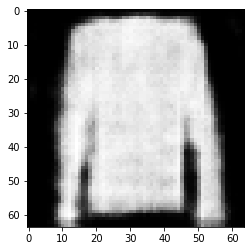

Epoch [30 / 50] average loss generator vs. discrim.: 2.081643 vs. 0.333483

Batch: 50 Generator Loss: 2.0984384322166445 Discriminator Loss: 0.3342120319604874
Batch: 100 Generator Loss: 2.0656507086753844 Discriminator Loss: 0.33341281712055204
Batch: 150 Generator Loss: 2.07678551197052 Discriminator Loss: 0.33370631992816924
Batch: 200 Generator Loss: 2.089155962467194 Discriminator Loss: 0.331385640501976
Batch: 250 Generator Loss: 2.1110217595100402 Discriminator Loss: 0.3380047160387039
Batch: 300 Generator Loss: 2.086078143119812 Discriminator Loss: 0.3324514329433441
Batch: 350 Generator Loss: 2.044420418739319 Discriminator Loss: 0.4312250643968582
Batch: 400 Generator Loss: 2.0736599159240723 Discriminator Loss: 0.3498585671186447
Batch: 450 Generator Loss: 1.9678754305839539 Discriminator Loss: 0.3526156783103943


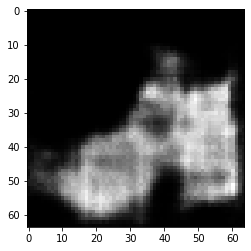

Epoch [31 / 50] average loss generator vs. discrim.: 2.064984 vs. 0.348128

Batch: 50 Generator Loss: 1.9888240194320679 Discriminator Loss: 0.339324409365654
Batch: 100 Generator Loss: 2.0205612659454344 Discriminator Loss: 0.3360752683877945
Batch: 150 Generator Loss: 2.0390973782539366 Discriminator Loss: 0.3378890341520309
Batch: 200 Generator Loss: 2.0516513323783876 Discriminator Loss: 0.33362343788146975
Batch: 250 Generator Loss: 2.0604275965690615 Discriminator Loss: 0.3370191103219986
Batch: 300 Generator Loss: 2.074258704185486 Discriminator Loss: 0.335745068192482
Batch: 350 Generator Loss: 2.0844578742980957 Discriminator Loss: 0.3349298298358917
Batch: 400 Generator Loss: 2.0854452872276306 Discriminator Loss: 0.3323900091648102
Batch: 450 Generator Loss: 2.065265839099884 Discriminator Loss: 0.3342647248506546


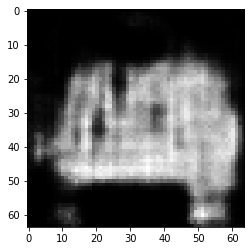

Epoch [32 / 50] average loss generator vs. discrim.: 2.052941 vs. 0.335800

Batch: 50 Generator Loss: 2.080872826576233 Discriminator Loss: 0.33365013360977175
Batch: 100 Generator Loss: 2.0750205612182615 Discriminator Loss: 0.33636557579040527
Batch: 150 Generator Loss: 2.047639470100403 Discriminator Loss: 0.33503910660743713
Batch: 200 Generator Loss: 2.0843797397613524 Discriminator Loss: 0.33731992423534396
Batch: 250 Generator Loss: 2.069076735973358 Discriminator Loss: 0.332863746881485
Batch: 300 Generator Loss: 2.0637083315849303 Discriminator Loss: 0.33420610904693604
Batch: 350 Generator Loss: 2.0624446773529055 Discriminator Loss: 0.3334247982501984
Batch: 400 Generator Loss: 2.0634897637367247 Discriminator Loss: 0.33608244359493256
Batch: 450 Generator Loss: 2.0650651168823244 Discriminator Loss: 0.334390829205513


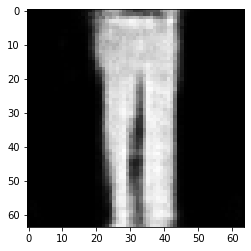

Epoch [33 / 50] average loss generator vs. discrim.: 2.066675 vs. 0.334716

Batch: 50 Generator Loss: 2.089083614349365 Discriminator Loss: 0.33608179092407225
Batch: 100 Generator Loss: 2.0650934839248656 Discriminator Loss: 0.33417851209640503
Batch: 150 Generator Loss: 2.064397385120392 Discriminator Loss: 0.33300936698913575
Batch: 200 Generator Loss: 2.0826253700256347 Discriminator Loss: 0.3379717594385147
Batch: 250 Generator Loss: 2.0729779243469237 Discriminator Loss: 0.3337343657016754
Batch: 300 Generator Loss: 2.067753915786743 Discriminator Loss: 0.3326708334684372
Batch: 350 Generator Loss: 2.080037715435028 Discriminator Loss: 0.33470304906368253
Batch: 400 Generator Loss: 2.095034558773041 Discriminator Loss: 0.33309963762760164
Batch: 450 Generator Loss: 2.096292929649353 Discriminator Loss: 0.33557004153728487


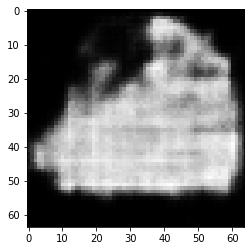

Epoch [34 / 50] average loss generator vs. discrim.: 2.079626 vs. 0.334574

Batch: 50 Generator Loss: 2.0875621128082273 Discriminator Loss: 0.3349785816669464
Batch: 100 Generator Loss: 2.101977243423462 Discriminator Loss: 0.3333244985342026
Batch: 150 Generator Loss: 2.084260597229004 Discriminator Loss: 0.3321782326698303
Batch: 200 Generator Loss: 2.098673369884491 Discriminator Loss: 0.3344718611240387
Batch: 250 Generator Loss: 2.0743081378936767 Discriminator Loss: 0.3332578605413437
Batch: 300 Generator Loss: 2.081170392036438 Discriminator Loss: 0.3349307256937027
Batch: 350 Generator Loss: 2.072637367248535 Discriminator Loss: 0.3332055962085724
Batch: 400 Generator Loss: 2.0887669205665587 Discriminator Loss: 0.3410972964763641
Batch: 450 Generator Loss: 2.0846355319023133 Discriminator Loss: 0.3320350170135498


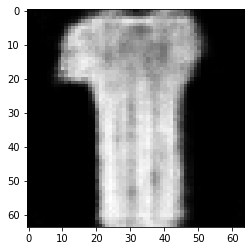

Epoch [35 / 50] average loss generator vs. discrim.: 2.085427 vs. 0.334321

Batch: 50 Generator Loss: 2.0774946284294127 Discriminator Loss: 0.3324160134792328
Batch: 100 Generator Loss: 2.08888861656189 Discriminator Loss: 0.3336438089609146
Batch: 150 Generator Loss: 2.0919523310661314 Discriminator Loss: 0.3327600187063217
Batch: 200 Generator Loss: 2.1087609124183655 Discriminator Loss: 0.3314991992712021
Batch: 250 Generator Loss: 2.0941819405555724 Discriminator Loss: 0.33316358387470246
Batch: 300 Generator Loss: 2.1118529176712038 Discriminator Loss: 0.3352195483446121
Batch: 350 Generator Loss: 2.0941417145729067 Discriminator Loss: 0.33151823461055757
Batch: 400 Generator Loss: 2.102497363090515 Discriminator Loss: 0.33587306320667265
Batch: 450 Generator Loss: 2.0890608716011045 Discriminator Loss: 0.3337486129999161


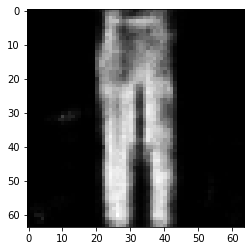

Epoch [36 / 50] average loss generator vs. discrim.: 2.095091 vs. 0.333255

Batch: 50 Generator Loss: 2.081277832984924 Discriminator Loss: 0.33308961510658264
Batch: 100 Generator Loss: 2.0763602590560915 Discriminator Loss: 0.3347951281070709
Batch: 150 Generator Loss: 2.0958211326599123 Discriminator Loss: 0.3346747040748596
Batch: 200 Generator Loss: 2.1067732214927672 Discriminator Loss: 0.33352789461612703
Batch: 250 Generator Loss: 2.0888440012931824 Discriminator Loss: 0.3350696051120758
Batch: 300 Generator Loss: 2.096493110656738 Discriminator Loss: 0.33347498953342436
Batch: 350 Generator Loss: 2.0845265340805055 Discriminator Loss: 0.3339088410139084
Batch: 400 Generator Loss: 1.9015993869304657 Discriminator Loss: 0.46831173181533814
Batch: 450 Generator Loss: 2.012278928756714 Discriminator Loss: 0.3718473297357559


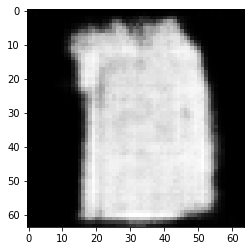

Epoch [37 / 50] average loss generator vs. discrim.: 2.054617 vs. 0.352781

Batch: 50 Generator Loss: 1.9848992705345154 Discriminator Loss: 0.3502954876422882
Batch: 100 Generator Loss: 2.0040457463264465 Discriminator Loss: 0.33791759312152864
Batch: 150 Generator Loss: 2.0673833417892458 Discriminator Loss: 0.3380533194541931
Batch: 200 Generator Loss: 2.054296293258667 Discriminator Loss: 0.3320818167924881
Batch: 250 Generator Loss: 2.0606698775291443 Discriminator Loss: 0.3315461564064026
Batch: 300 Generator Loss: 2.0807622408866884 Discriminator Loss: 0.3347645354270935
Batch: 350 Generator Loss: 2.103797218799591 Discriminator Loss: 0.3321964514255524
Batch: 400 Generator Loss: 2.0861097598075866 Discriminator Loss: 0.33274110555648806
Batch: 450 Generator Loss: 2.0688958764076233 Discriminator Loss: 0.3332328522205353


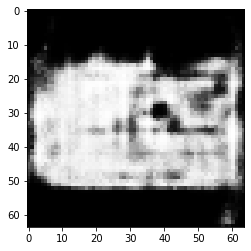

Epoch [38 / 50] average loss generator vs. discrim.: 2.057458 vs. 0.335651

Batch: 50 Generator Loss: 2.080899467468262 Discriminator Loss: 0.3332146579027176
Batch: 100 Generator Loss: 2.075445017814636 Discriminator Loss: 0.3303324002027512
Batch: 150 Generator Loss: 2.077096452713013 Discriminator Loss: 0.33327495872974394
Batch: 200 Generator Loss: 2.0773838686943056 Discriminator Loss: 0.3325709730386734
Batch: 250 Generator Loss: 2.071383934020996 Discriminator Loss: 0.3331461775302887
Batch: 300 Generator Loss: 2.065372357368469 Discriminator Loss: 0.3335316604375839
Batch: 350 Generator Loss: 2.0859136533737184 Discriminator Loss: 0.3331615447998047
Batch: 400 Generator Loss: 2.0936365056037904 Discriminator Loss: 0.33308560252189634
Batch: 450 Generator Loss: 2.097853922843933 Discriminator Loss: 0.33498078227043154


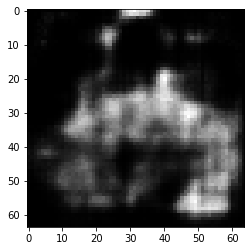

Epoch [39 / 50] average loss generator vs. discrim.: 2.081353 vs. 0.332946

Batch: 50 Generator Loss: 2.068573708534241 Discriminator Loss: 0.33181059658527373
Batch: 100 Generator Loss: 2.0897353363037108 Discriminator Loss: 0.3339302510023117
Batch: 150 Generator Loss: 2.084457540512085 Discriminator Loss: 0.33127360105514525
Batch: 200 Generator Loss: 2.0843635988235474 Discriminator Loss: 0.3311572015285492
Batch: 250 Generator Loss: 2.085001447200775 Discriminator Loss: 0.33385421872138976
Batch: 300 Generator Loss: 2.102514090538025 Discriminator Loss: 0.3321964639425278
Batch: 350 Generator Loss: 2.099367663860321 Discriminator Loss: 0.3317968624830246
Batch: 400 Generator Loss: 2.1123340916633606 Discriminator Loss: 0.33467541098594666
Batch: 450 Generator Loss: 2.088467357158661 Discriminator Loss: 0.3329773831367493


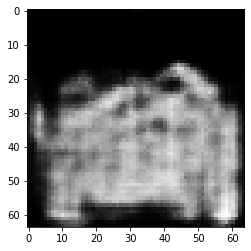

Epoch [40 / 50] average loss generator vs. discrim.: 2.089922 vs. 0.332515

Batch: 50 Generator Loss: 2.099187664985657 Discriminator Loss: 0.3342600750923157
Batch: 100 Generator Loss: 2.1012415742874144 Discriminator Loss: 0.33147204518318174
Batch: 150 Generator Loss: 2.0854005932807924 Discriminator Loss: 0.33147055506706236
Batch: 200 Generator Loss: 2.0829983067512514 Discriminator Loss: 0.3322252029180527
Batch: 250 Generator Loss: 2.0787118649482728 Discriminator Loss: 0.3332749354839325
Batch: 300 Generator Loss: 2.087109773159027 Discriminator Loss: 0.3331689417362213
Batch: 350 Generator Loss: 1.9846291399002076 Discriminator Loss: 0.41362603843212126
Batch: 400 Generator Loss: 2.047049114704132 Discriminator Loss: 0.35250279784202576
Batch: 450 Generator Loss: 2.032737410068512 Discriminator Loss: 0.3418236666917801


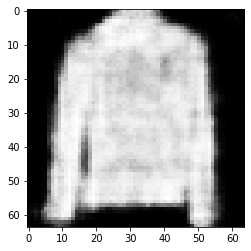

Epoch [41 / 50] average loss generator vs. discrim.: 2.066442 vs. 0.344467

Batch: 50 Generator Loss: 2.048204061985016 Discriminator Loss: 0.33318680167198184
Batch: 100 Generator Loss: 2.064632546901703 Discriminator Loss: 0.3349781912565231
Batch: 150 Generator Loss: 2.0786933946609496 Discriminator Loss: 0.3325356304645538
Batch: 200 Generator Loss: 2.0799410700798036 Discriminator Loss: 0.3341758668422699
Batch: 250 Generator Loss: 2.071081109046936 Discriminator Loss: 0.3320228570699692
Batch: 300 Generator Loss: 2.074509756565094 Discriminator Loss: 0.3328388392925262
Batch: 350 Generator Loss: 2.0832406091690063 Discriminator Loss: 0.3325975960493088
Batch: 400 Generator Loss: 2.071974415779114 Discriminator Loss: 0.3351257413625717
Batch: 450 Generator Loss: 2.085269310474396 Discriminator Loss: 0.33125683188438415


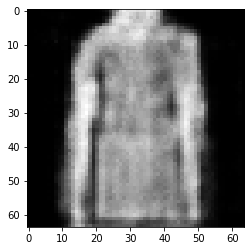

Epoch [42 / 50] average loss generator vs. discrim.: 2.073218 vs. 0.333319

Batch: 50 Generator Loss: 2.0715467882156373 Discriminator Loss: 0.33442666530609133
Batch: 100 Generator Loss: 2.0690515542030337 Discriminator Loss: 0.33262907326221464
Batch: 150 Generator Loss: 2.0927941036224365 Discriminator Loss: 0.33361113667488096
Batch: 200 Generator Loss: 2.08241411447525 Discriminator Loss: 0.33234370827674864
Batch: 250 Generator Loss: 2.091156847476959 Discriminator Loss: 0.3317187201976776
Batch: 300 Generator Loss: 2.0953131222724917 Discriminator Loss: 0.33277216732501985
Batch: 350 Generator Loss: 2.0782315635681154 Discriminator Loss: 0.33275097846984864
Batch: 400 Generator Loss: 2.0810236167907714 Discriminator Loss: 0.3329293018579483
Batch: 450 Generator Loss: 2.076307199001312 Discriminator Loss: 0.3308576589822769


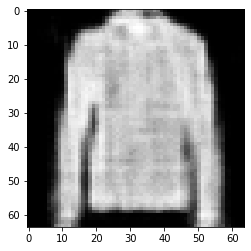

Epoch [43 / 50] average loss generator vs. discrim.: 2.081097 vs. 0.332565

Batch: 50 Generator Loss: 2.084645109176636 Discriminator Loss: 0.3315485167503357
Batch: 100 Generator Loss: 2.090707387924194 Discriminator Loss: 0.3323466819524765
Batch: 150 Generator Loss: 2.0793182015419007 Discriminator Loss: 0.3313470506668091
Batch: 200 Generator Loss: 2.0983283710479737 Discriminator Loss: 0.33333574652671816
Batch: 250 Generator Loss: 2.0916968822479247 Discriminator Loss: 0.3331931972503662
Batch: 300 Generator Loss: 2.0906552124023436 Discriminator Loss: 0.3338918435573578
Batch: 350 Generator Loss: 2.0907419657707216 Discriminator Loss: 0.33123126804828645
Batch: 400 Generator Loss: 2.09577684879303 Discriminator Loss: 0.3330827814340591
Batch: 450 Generator Loss: 2.084592890739441 Discriminator Loss: 0.33151124775409696


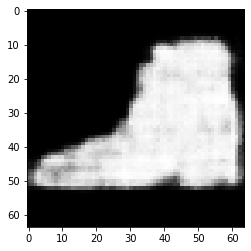

Epoch [44 / 50] average loss generator vs. discrim.: 2.089046 vs. 0.332436

Batch: 50 Generator Loss: 2.0804102969169618 Discriminator Loss: 0.33252141177654265
Batch: 100 Generator Loss: 2.0885895609855654 Discriminator Loss: 0.32963219165802005
Batch: 150 Generator Loss: 2.0946053886413574 Discriminator Loss: 0.3345712172985077
Batch: 200 Generator Loss: 2.086332697868347 Discriminator Loss: 0.33050926864147184
Batch: 250 Generator Loss: 2.0857022047042846 Discriminator Loss: 0.3305776023864746
Batch: 300 Generator Loss: 2.086566104888916 Discriminator Loss: 0.33126069903373717
Batch: 350 Generator Loss: 2.0876585268974304 Discriminator Loss: 0.33190184652805327
Batch: 400 Generator Loss: 2.106072781085968 Discriminator Loss: 0.3338141816854477
Batch: 450 Generator Loss: 2.097009401321411 Discriminator Loss: 0.33203102052211764


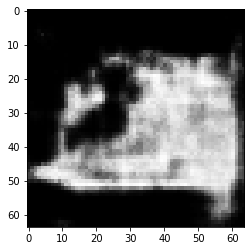

Epoch [45 / 50] average loss generator vs. discrim.: 2.089173 vs. 0.331880

Batch: 50 Generator Loss: 2.077904231548309 Discriminator Loss: 0.33035954236984255
Batch: 100 Generator Loss: 2.0964365816116333 Discriminator Loss: 0.3339329653978348
Batch: 150 Generator Loss: 2.0990701627731325 Discriminator Loss: 0.3303697991371155
Batch: 200 Generator Loss: 2.080385329723358 Discriminator Loss: 0.32946585178375243
Batch: 250 Generator Loss: 2.094092996120453 Discriminator Loss: 0.3326630538702011
Batch: 300 Generator Loss: 2.0936026883125307 Discriminator Loss: 0.33203398048877714
Batch: 350 Generator Loss: 2.0836452722549437 Discriminator Loss: 0.33199315071105956
Batch: 400 Generator Loss: 2.067175279855728 Discriminator Loss: 0.4193820214271545
Batch: 450 Generator Loss: 2.2652913165092468 Discriminator Loss: 0.36859600484371186


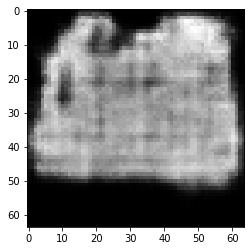

Epoch [46 / 50] average loss generator vs. discrim.: 2.099125 vs. 0.345843

Batch: 50 Generator Loss: 1.9849164986610413 Discriminator Loss: 0.3386274755001068
Batch: 100 Generator Loss: 2.020956270694733 Discriminator Loss: 0.33965650796890257
Batch: 150 Generator Loss: 2.0396015214920045 Discriminator Loss: 0.3345873564481735
Batch: 200 Generator Loss: 2.0432830572128298 Discriminator Loss: 0.3360565495491028
Batch: 250 Generator Loss: 2.0596457862854005 Discriminator Loss: 0.3364200735092163
Batch: 300 Generator Loss: 2.0423217606544495 Discriminator Loss: 0.33460407495498656
Batch: 350 Generator Loss: 2.0685075759887694 Discriminator Loss: 0.33062475264072416
Batch: 400 Generator Loss: 2.070496728420258 Discriminator Loss: 0.33345344841480257
Batch: 450 Generator Loss: 2.0926732301712034 Discriminator Loss: 0.3336524987220764


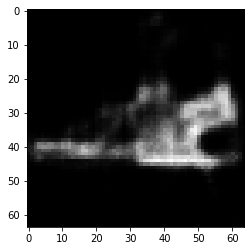

Epoch [47 / 50] average loss generator vs. discrim.: 2.048142 vs. 0.335196

Batch: 50 Generator Loss: 2.085423777103424 Discriminator Loss: 0.3323246544599533
Batch: 100 Generator Loss: 2.085618019104004 Discriminator Loss: 0.33268337666988373
Batch: 150 Generator Loss: 2.1027340149879454 Discriminator Loss: 0.3331458616256714
Batch: 200 Generator Loss: 2.097389578819275 Discriminator Loss: 0.33166002333164213
Batch: 250 Generator Loss: 2.08046692609787 Discriminator Loss: 0.3323658686876297
Batch: 300 Generator Loss: 2.094998683929443 Discriminator Loss: 0.33120199263095856
Batch: 350 Generator Loss: 2.0795130228996275 Discriminator Loss: 0.33277879416942596
Batch: 400 Generator Loss: 2.0817311143875123 Discriminator Loss: 0.3306560492515564
Batch: 450 Generator Loss: 2.092360272407532 Discriminator Loss: 0.331636518239975


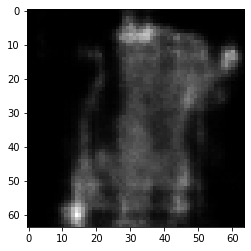

Epoch [48 / 50] average loss generator vs. discrim.: 2.088791 vs. 0.332117

Batch: 50 Generator Loss: 2.096431641578674 Discriminator Loss: 0.3313184708356857
Batch: 100 Generator Loss: 2.0859177470207215 Discriminator Loss: 0.33182383596897125
Batch: 150 Generator Loss: 2.110810356140137 Discriminator Loss: 0.3333455431461334
Batch: 200 Generator Loss: 2.1004715394973754 Discriminator Loss: 0.3325281047821045
Batch: 250 Generator Loss: 2.0740859007835386 Discriminator Loss: 0.3326565623283386
Batch: 300 Generator Loss: 2.1194217133522035 Discriminator Loss: 0.33443831026554105
Batch: 350 Generator Loss: 2.095434193611145 Discriminator Loss: 0.33455701112747194
Batch: 400 Generator Loss: 2.0846452164649962 Discriminator Loss: 0.3303699940443039
Batch: 450 Generator Loss: 2.100751266479492 Discriminator Loss: 0.33257120549678804


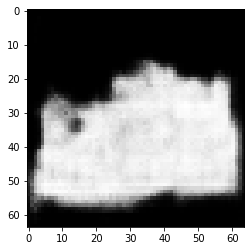

Epoch [49 / 50] average loss generator vs. discrim.: 2.096235 vs. 0.332600

Batch: 50 Generator Loss: 2.08800035238266 Discriminator Loss: 0.3298629516363144
Batch: 100 Generator Loss: 2.0792222881317137 Discriminator Loss: 0.33065532326698305
Batch: 150 Generator Loss: 2.0967723393440245 Discriminator Loss: 0.33157936215400696
Batch: 200 Generator Loss: 2.0924605107307435 Discriminator Loss: 0.3316327530145645
Batch: 250 Generator Loss: 2.0970811009407044 Discriminator Loss: 0.3345173442363739
Batch: 300 Generator Loss: 2.111971344947815 Discriminator Loss: 0.3336528116464615
Batch: 350 Generator Loss: 2.0956251215934754 Discriminator Loss: 0.3321006458997726
Batch: 400 Generator Loss: 2.0925711226463317 Discriminator Loss: 0.33062732458114624
Batch: 450 Generator Loss: 2.074999568462372 Discriminator Loss: 0.32965762734413145


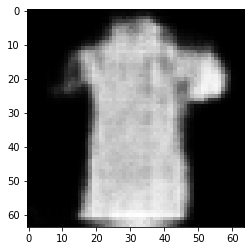

Epoch [50 / 50] average loss generator vs. discrim.: 2.092079 vs. 0.331614



In [4]:
learning_rate = 1e-5
num_epochs = 50

gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    running_loss_1 = 0.0
    running_loss_2 = 0.0

    generator.train()
    discriminator.train()
    
    for i,(image_batch, _) in enumerate(train_dataloader):
        
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)*0.9
        label_fake = torch.ones(image_batch.size(0), device=device)*0.1

        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

        running_loss_1 += gen_loss.item()
        running_loss_2 += disc_loss.item()

        if i%50 == 49:
          print("Batch:",i+1,"Generator Loss:",running_loss_1/50,"Discriminator Loss:",running_loss_2/50)
          running_loss_1 = 0.0
          running_loss_2 = 0.0
        
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    generator.eval()
    z = torch.randn(1, 100, 1, 1, device=device)
    epoch_pred = generator(z)
    img = epoch_pred.view(64, 64).detach().cpu().numpy()

    plt.imshow((img+1.)/2.,cmap='gray')
    plt.show()
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %(epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))
    print("")

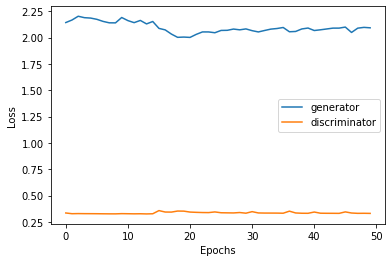

In [5]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

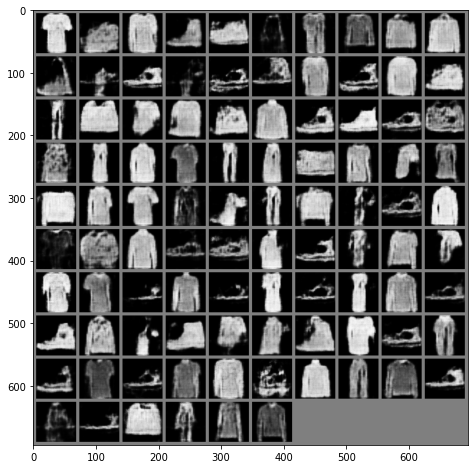

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    plt.show()

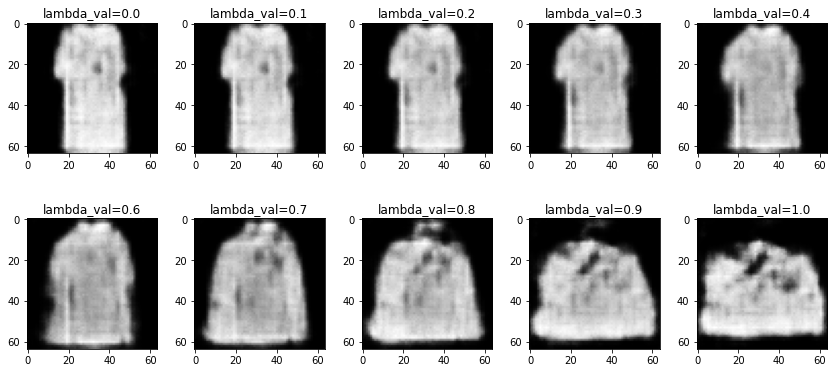

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

In [8]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
PATH = '/content/gdrive/My Drive/Pytorch_Practice/DCGAN_FashionMNIST_generator.pt'
torch.save(generator,PATH)

PATH = '/content/gdrive/My Drive/Pytorch_Practice/DCGAN_FashionMNIST_discriminator.pt'
torch.save(discriminator,PATH)